# Data Quality Processing for MagnusWeb Dataset

## Objective
This notebook implements a comprehensive data quality pipeline for the MagnusWeb panel dataset, following academic best practices for econometric analysis. The pipeline:

1. **Preserves data integrity** while removing clear data quality issues
2. **Handles missing data** using appropriate imputation strategies
3. **Identifies and treats outliers** using robust statistical methods
4. **Maintains sufficient sample size** for reliable econometric inference
5. **Documents all transformations** for reproducibility

## Output
- Single cleaned dataset: `magnusweb_panel_imputed.parquet`
- Comprehensive data quality documentation

In [47]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Dict
import pandas as pd

pd.set_option('display.max_rows', 100) 

# --- Configuration Constants ---

# Data Filtering
START_YEAR = 2000                   # ◀ Filter data to begin from this year
MIN_REPORTING_YEARS = 3             # Minimum years required per firm
MIN_EMPLOYEES = 10                  # Minimum number of employees

# Outlier Detection & Treatment
OUTLIER_RZ_THRESHOLD = 5.0          # ◀ Robust z-score threshold (more conservative)
YOY_JUMP_THRESHOLD = 20.0           # ◀ YoY jump threshold (diagnostic only, not for removal)
MAX_BALANCE_SHEET_GAP = 0.25        # Maximum allowed balance sheet gap (25%)

# Winsorisation
WINSOR_LOWER_Q = 0.01               # ◀ More conservative winsorisation quantiles
WINSOR_UPPER_Q = 0.99               # ◀ More conservative winsorisation quantiles
WINSOR_GROWTH_LOWER_Q = 0.05        # ◀ More aggressive winsorisation for volatile growth rates
WINSOR_GROWTH_UPPER_Q = 0.95        # ◀ More aggressive winsorisation for volatile growth rates

DROP_OUTLIERS = True               # ◀ Whether to drop outliers after winsorisation

# --- Input and Output Paths ---
input_path = os.path.join("..", "data", "source_cleaned", "magnusweb_panel.parquet")
output_path = os.path.join("..", "data", "source_cleaned", "magnusweb_panel_imputed.parquet")

# --- Column Groups for Processing ---
FINANCIAL_COLS = [
    'profit_pre_tax', 'total_liabilities_and_equity', 'oper_profit', 
    'total_assets', 'profit_net', 'sales_revenue', 'equity', 'turnover', 'costs'
]
RATIO_COLS = [
    "operating_margin_cal", "net_margin_cal", "cost_ratio_cal", 
    "roa_ebit_cal", "roe_cal", "equity_ratio_cal", "effective_tax_rate_cal",
    "asset_turnover_cal", "labor_productivity_cal" 
]
GROWTH_COLS = [
    "rev_growth_cal", "cost_growth_cal", "op_profit_growth_cal"
]

# --- Load Initial Data ---
print("📁 Loading MagnusWeb panel dataset...")
panel = pl.read_parquet(input_path)
print(f"✅ Initial loaded panel shape: {panel.shape}")

# Filter data from START_YEAR
panel = panel.filter(pl.col("year") >= START_YEAR)
print(f"✅ Panel shape after filtering for year >= {START_YEAR}: {panel.shape}")
print(f"   Time span: {panel['year'].min()}-{panel['year'].max()}")
print(f"   Unique firms: {panel['ico'].n_unique():,}")

initial_shape = panel.shape

📁 Loading MagnusWeb panel dataset...
✅ Initial loaded panel shape: (1754304, 40)
✅ Panel shape after filtering for year >= 2000: (1754304, 40)
   Time span: 2000-2023
   Unique firms: 73,096


In [48]:
print("\n" + "=" * 80)
print("STEP 0: Initial Data Cleaning and Enrichment")
print("=" * 80)

# 0.1 Correct data types
print("🔧 Correcting data types...")
panel = panel.with_columns([
    pl.col(['num_employees_cat', 'status', 'legal_form', 'entity_type']).cast(pl.Categorical),
    pl.col(['date_founded', 'date_dissolved']).str.strptime(pl.Date, "%Y-%m-%d", strict=False)
])
print("   ✅ Data types corrected.")

# 0.2 Filter by employee count
print(f"\n🔧 Filtering for firms with >= {MIN_EMPLOYEES} employees...")
before_employee_filter = panel.shape
panel = panel.filter(pl.col("num_employees") >= MIN_EMPLOYEES)
print(f"   Removed {before_employee_filter[0] - panel.shape[0]:,} observations.")
print(f"   Shape after employee filter: {panel.shape}")

# 0.3 Remove rows with missing ICO
print("\n🔧 Removing rows with missing ICO...")
before_ico_filter = panel.shape
panel = panel.filter(pl.col("ico").is_not_null() & (pl.col("ico") != ""))
print(f"   Removed {before_ico_filter[0] - panel.shape[0]:,} observations.")
print(f"   Shape after ICO filter: {panel.shape}")

# 0.4 Add year founded/dissolved columns
print("\n🔧 Adding year founded/dissolved columns...")
panel = panel.with_columns([
    pl.col("date_founded").dt.year().alias("year_founded"),
    pl.col("date_dissolved").dt.year().alias("year_dissolved"),
    pl.when(pl.col("date_dissolved").is_not_null()).then(True).otherwise(False).alias("is_dissolved"),
])
print("   ✅ Year columns added.")

print(f"\n✅ Step 0 complete: Initial cleaning and enrichment applied.")


STEP 0: Initial Data Cleaning and Enrichment
🔧 Correcting data types...
   ✅ Data types corrected.

🔧 Filtering for firms with >= 10 employees...
   Removed 469,176 observations.
   Shape after employee filter: (1285128, 40)

🔧 Removing rows with missing ICO...
   Removed 24 observations.
   Shape after ICO filter: (1285104, 40)

🔧 Adding year founded/dissolved columns...
   ✅ Year columns added.

✅ Step 0 complete: Initial cleaning and enrichment applied.


In [49]:
# %%
pd.set_option('display.max_rows', 100) 

# 0.5 Filter for Corporate Sector (Non-Financial Enterprises)
print("\n" + "-" * 60)
print("Step 0.5: Filtering for the Non-Financial Corporate Sector")
print("-" * 60)

# --- Define Whitelists ---
whitelist_legal_forms = [
    'Společnost s ručením omezeným',
    'Akciová společnost',
    'Družstvo',
    'Komanditní společnost',
    'Veřejná obchodní společnost',
    'Evropská společnost',
    'Zdravoní pojišťovna',
    'Pojišťovna - akciová společnost',
    'Banka - akciová společnost',
    'Komoditní burza'
]

whitelist_entity_types = [
    'Podnik',
    'Družstvo',
    # below are financial entities - decide on whether to keep or remove - different cost structure compared to non-financial firms
    'Pojišťovna',
    'Banka',
    'Investiční společnost',
    'Penzijní fond',
    'Fond kolektivního investování'
]

# --- Capture Pre-Filter State ---
print("Analyzing pre-filter firm composition...")
before_filter_shape = panel.shape
before_total_firms = panel['ico'].n_unique()

# Group by legal_form and entity_type to get unique ICO counts for each
pre_filter_legal_forms = panel.group_by("legal_form").agg(pl.col("ico").n_unique().alias("unique_firm_count"))
pre_filter_entity_types = panel.group_by("entity_type").agg(pl.col("ico").n_unique().alias("unique_firm_count"))


# --- Apply Filters ---
# Stage 1: Filter by Legal Form
panel_after_legal_form = panel.filter(
    pl.col("legal_form").is_in(whitelist_legal_forms)
)

# Stage 2: Filter by Entity Type
panel_final = panel_after_legal_form.filter(
    pl.col("entity_type").is_in(whitelist_entity_types)
)


# --- Document and Print Removals (Based on Unique Firms) ---
# Identify and print removed legal forms by unique firm count
removed_legal_forms = pre_filter_legal_forms.filter(
    ~pl.col("legal_form").is_in(whitelist_legal_forms)
).sort("unique_firm_count", descending=True)

print("\n[Documentation] Legal Forms REMOVED (by unique firm count):")

# Display all rows of removed legal forms (up to the full DataFrame height)
if removed_legal_forms.height > 0:
    # Use Polars' to_pandas() for full display control if needed
    pd.set_option('display.max_rows', removed_legal_forms.height)
    display(removed_legal_forms.to_pandas())
    # Reset max_rows to default after display to avoid side effects
    pd.set_option('display.max_rows', 100)
else:
    print("   None.")

# Identify and print removed entity types from the already legal-form-filtered data
post_legal_form_entity_types = panel_after_legal_form.group_by("entity_type").agg(pl.col("ico").n_unique().alias("unique_firm_count"))
removed_entity_types = post_legal_form_entity_types.filter(
    ~pl.col("entity_type").is_in(whitelist_entity_types)
).sort("unique_firm_count", descending=True)

print("\n[Documentation] Entity Types REMOVED from corporate legal forms (by unique firm count):")
if removed_entity_types.height > 0:
    display(removed_entity_types)
else:
    print("   None.")


# --- Final Summary ---
after_total_firms = panel_final['ico'].n_unique()
print("\n--- Filtering Summary ---")
print(f"Initial unique firms: {before_total_firms:,}")
print(f"Removed {before_total_firms - after_total_firms:,} unique firms.")
print(f"Final unique firms in sample: {after_total_firms:,}")
print(f"Final observations in sample: {panel_final.shape[0]:,}")

# Update the main panel variable
panel = panel_final

# Final check of remaining entity types by unique firm count
print("\n[Documentation] Entity Types REMAINING in the final sample (by unique firm count):")
print(panel.group_by("entity_type").agg(pl.col("ico").n_unique().alias("unique_firm_count")))


------------------------------------------------------------
Step 0.5: Filtering for the Non-Financial Corporate Sector
------------------------------------------------------------
Analyzing pre-filter firm composition...

[Documentation] Legal Forms REMOVED (by unique firm count):


,legal_form,unique_firm_count
0,Fyzická osoba podnikající dle živnostenského z...,699
1,Odštěpný závod zahraniční právnické osoby,254
2,Obecně prospěšná společnost,217
3,Příspěvková organizace,167
4,Zahraniční osoba,162
5,Fyzická osoba podnikající dle jiných zákonů ne...,138
6,Zemědělský podnikatel - fyzická osoba,68
7,Státní příspěvková organizace,61
8,Ústav,54
9,Organizační složka státu,51



[Documentation] Entity Types REMOVED from corporate legal forms (by unique firm count):


entity_type,unique_firm_count
cat,u32
"""Jiný subjekt""",1



--- Filtering Summary ---
Initial unique firms: 53,546
Removed 2,192 unique firms.
Final unique firms in sample: 51,354
Final observations in sample: 1,232,496

[Documentation] Entity Types REMAINING in the final sample (by unique firm count):
shape: (7, 2)
┌───────────────────────────────┬───────────────────┐
│ entity_type                   ┆ unique_firm_count │
│ ---                           ┆ ---               │
│ cat                           ┆ u32               │
╞═══════════════════════════════╪═══════════════════╡
│ Banka                         ┆ 30                │
│ Investiční společnost         ┆ 23                │
│ Podnik                        ┆ 50265             │
│ Pojišťovna                    ┆ 38                │
│ Fond kolektivního investování ┆ 7                 │
│ Penzijní fond                 ┆ 14                │
│ Družstvo                      ┆ 977               │
└───────────────────────────────┴───────────────────┘


In [50]:
print("=" * 80)
print("STEP 1: Dataset Structure and Initial Assessment")
print("=" * 80)

# 1.1 Panel structure analysis
print(f"\n🔍 Panel structure:")
print(f"   Shape: {panel.shape[0]:,} observations × {panel.shape[1]} variables")
print(f"   Time span: {panel['year'].min()}-{panel['year'].max()}")
print(f"   Unique firms: {panel['ico'].n_unique():,}")

# Years per firm distribution
years_per_firm = (
    panel.group_by("ico")
    .agg(pl.col("year").count().alias("years_count"))
)

# Get value counts for years distribution
years_distribution = (
    years_per_firm
    .group_by("years_count")
    .agg(pl.len().alias("count"))
    .sort("years_count")
)

print(f"\n📊 Firm tenure distribution:")
for row in years_distribution.iter_rows():
    years, count = row
    pct = count / panel['ico'].n_unique() * 100
    print(f"   {years:2d} years: {count:8,} firms ({pct:5.1f}%)")

# 1.2 Data availability analysis
print(f"\n📈 Data availability by variable group:")

def analyze_availability(cols: List[str], group_name: str):
    if not any(col in panel.columns for col in cols):
        print(f"   {group_name}: No columns found")
        return
    
    available_cols = [col for col in cols if col in panel.columns]
    total_possible = len(available_cols) * panel.shape[0]
    total_observed = sum(panel[col].count() for col in available_cols)
    
    print(f"   {group_name}: {total_observed:,}/{total_possible:,} ({total_observed/total_possible*100:.1f}%)")
    
    # Show worst and best coverage
    coverages = [(col, panel[col].count() / panel.shape[0]) for col in available_cols]
    coverages.sort(key=lambda x: x[1])
    
    print(f"     Lowest coverage: {coverages[0][0]} ({coverages[0][1]*100:.1f}%)")
    print(f"     Highest coverage: {coverages[-1][0]} ({coverages[-1][1]*100:.1f}%)")

analyze_availability(FINANCIAL_COLS, "Financial variables")
analyze_availability(RATIO_COLS, "Calculated ratios")
analyze_availability(GROWTH_COLS, "Growth variables")

# 1.3 Firm lifecycle analysis
if all(col in panel.columns for col in ["year_founded", "year_dissolved"]):
    lifecycle_stats = panel.select([
        "ico", "year_founded", "year_dissolved", "year"
    ]).group_by("ico").agg([
        pl.col("year_founded").first().alias("founded"),
        pl.col("year_dissolved").first().alias("dissolved"),
        pl.col("year").min().alias("first_report"),
        pl.col("year").max().alias("last_report")
    ])
    
    active_firms = lifecycle_stats.filter(pl.col("dissolved").is_null()).shape[0]
    dissolved_firms = lifecycle_stats.filter(pl.col("dissolved").is_not_null()).shape[0]
    
    print(f"\n🏢 Firm lifecycle:")
    print(f"   Active firms: {active_firms:,} ({active_firms/panel['ico'].n_unique()*100:.1f}%)")
    print(f"   Dissolved firms: {dissolved_firms:,} ({dissolved_firms/panel['ico'].n_unique()*100:.1f}%)")

print(f"\n✅ Step 1 complete: Dataset structure analyzed")

STEP 1: Dataset Structure and Initial Assessment

🔍 Panel structure:
   Shape: 1,232,496 observations × 43 variables
   Time span: 2000-2023
   Unique firms: 51,354

📊 Firm tenure distribution:
   24 years:   51,354 firms (100.0%)

📈 Data availability by variable group:
   Financial variables: 5,643,322/11,092,464 (50.9%)
     Lowest coverage: sales_revenue (49.4%)
     Highest coverage: total_assets (54.2%)
   Calculated ratios: No columns found
   Growth variables: No columns found

🏢 Firm lifecycle:
   Active firms: 41,232 (80.3%)
   Dissolved firms: 10,122 (19.7%)

✅ Step 1 complete: Dataset structure analyzed


In [51]:
print("\n" + "=" * 80)
print("STEP 2: Temporal Filtering and Firm Viability")
print("=" * 80)

print(f"Starting shape: {panel.shape}")
before_temporal = panel.shape[0]

# 2.1 Remove non-viable firm-years based on lifecycle
if "year_founded" in panel.columns:
    before_founded = panel.shape[0]
    panel = panel.filter(
        pl.col("year") >= pl.col("year_founded").fill_null(1900)
    )
    removed_founded = before_founded - panel.shape[0]
    print(f"Removed {removed_founded:,} observations before founding year")

if "year_dissolved" in panel.columns:
    before_dissolved = panel.shape[0]
    panel = panel.filter(
        (pl.col("year_dissolved").is_null()) | (pl.col("year") <= pl.col("year_dissolved"))
    )
    removed_dissolved = before_dissolved - panel.shape[0]
    print(f"Removed {removed_dissolved:,} observations after dissolution year")

# 2.2 Remove firm-years with all financial data missing
print(f"\nIdentifying non-reporting firm-years...")

# Define condition for non-reporting (all key financial variables are null)
all_null_condition = pl.all_horizontal([
    pl.col(col).is_null() for col in FINANCIAL_COLS if col in panel.columns
])

before_null_filter = panel.shape[0]
non_reporting_count = panel.filter(all_null_condition).shape[0]
panel = panel.filter(~all_null_condition)
after_null_filter = panel.shape[0]

print(f"Removed {non_reporting_count:,} non-reporting firm-years")

# 2.3 Require minimum reporting tenure per firm
print(f"\nApplying minimum reporting requirement ({MIN_REPORTING_YEARS} years)...")

firm_year_counts = panel.group_by("ico").agg(
    pl.col("year").count().alias("year_count")
)

viable_firms = firm_year_counts.filter(
    pl.col("year_count") >= MIN_REPORTING_YEARS
)["ico"].to_list()

before_min_years = panel.shape[0]
dropped_firms = panel["ico"].n_unique() - len(viable_firms)

panel = panel.filter(pl.col("ico").is_in(viable_firms))
after_min_years = panel.shape[0]

print(f"Removed {dropped_firms:,} firms with insufficient reporting")
print(f"Removed {before_min_years - after_min_years:,} observations from insufficient firms")

# 2.4 Summary
after_temporal = panel.shape[0]
total_removed = before_temporal - after_temporal

print(f"\nTemporal filtering summary:")
print(f"   Removed observations: {total_removed:,} ({total_removed/before_temporal*100:.1f}%)")
print(f"   Remaining observations: {after_temporal:,}")
print(f"   Remaining firms: {panel['ico'].n_unique():,}")
print(f"   Average years per firm: {after_temporal/panel['ico'].n_unique():.1f}")

print(f"\nStep 2 complete: Temporal filtering applied")


STEP 2: Temporal Filtering and Firm Viability
Starting shape: (1232496, 43)
Removed 264,291 observations before founding year
Removed 65,768 observations after dissolution year

Identifying non-reporting firm-years...
Removed 233,672 non-reporting firm-years

Applying minimum reporting requirement (3 years)...
Removed 2,348 firms with insufficient reporting
Removed 3,992 observations from insufficient firms

Temporal filtering summary:
   Removed observations: 567,723 (46.1%)
   Remaining observations: 664,773
   Remaining firms: 47,972
   Average years per firm: 13.9

Step 2 complete: Temporal filtering applied


In [52]:
print("\n" + "=" * 80)
print("STEP 3: Outlier Detection and Data Quality Assessment")
print("=" * 80)

def detect_outliers_robust_z(df: pl.DataFrame, cols: List[str], threshold: float = OUTLIER_RZ_THRESHOLD) -> pl.DataFrame:
    """
    Detect outliers using robust z-score (median + MAD) within each firm.
    This preserves legitimate business variations while catching data entry errors.
    """
    print(f"🔍 Detecting robust z-score outliers (threshold: {threshold})")
    
    outlier_summary = []
    
    for col in cols:
        if col not in df.columns:
            continue
            
        # Calculate firm-level median and MAD
        firm_stats = (
            df.filter(pl.col(col).is_not_null())
            .group_by("ico")
            .agg([
                pl.col(col).median().alias(f"{col}_median"),
                (pl.col(col) - pl.col(col).median()).abs().median().alias(f"{col}_mad")
            ])
        )
        
        # Join back to main data
        df = df.join(firm_stats, on="ico", how="left")
        
        # Calculate robust z-score: 0.6745 * (x - median) / MAD
        df = df.with_columns([
            pl.when(pl.col(f"{col}_mad") > 0)
              .then(0.6745 * (pl.col(col) - pl.col(f"{col}_median")) / pl.col(f"{col}_mad"))
              .otherwise(None)
              .alias(f"{col}_rz")
        ])
        
        # Flag outliers
        df = df.with_columns([
            (pl.col(f"{col}_rz").abs() > threshold).fill_null(False).alias(f"{col}_outlier")
        ])
        
        # Count outliers
        n_outliers = df.filter(pl.col(f"{col}_outlier")).shape[0]
        n_valid = df.filter(pl.col(col).is_not_null()).shape[0]
        
        outlier_summary.append((col, n_outliers, n_valid))
        
        # Clean up temporary columns
        df = df.drop([f"{col}_median", f"{col}_mad", f"{col}_rz"])
    
    # Print summary
    print(f"\n📊 Robust z-score outlier detection results:")
    for col, n_out, n_valid in outlier_summary:
        pct = n_out / n_valid * 100 if n_valid > 0 else 0
        print(f"   {col:30s}: {n_out:6,} outliers ({pct:5.2f}% of {n_valid:,})")
    
    return df

def detect_yoy_jumps(df: pl.DataFrame, cols: List[str], threshold: float = YOY_JUMP_THRESHOLD) -> pl.DataFrame:
    """
    Detect unrealistic year-over-year changes that suggest data quality issues.
    Uses multiplicative threshold (e.g., 5x increase/decrease).
    """
    print(f"\n🔍 Detecting year-over-year jumps (threshold: {threshold}x)")
    
    jump_summary = []
    df = df.sort(["ico", "year"])
    
    for col in cols:
        if col not in df.columns:
            continue
            
        # Calculate year-over-year ratio within each firm
        df = df.with_columns([
            (pl.col(col) / pl.col(col).shift(1)).over("ico").alias(f"{col}_yoy")
        ])
        
        # Flag jumps (both up and down)
        df = df.with_columns([
            ((pl.col(f"{col}_yoy") > threshold) | 
             (pl.col(f"{col}_yoy") < 1/threshold)).fill_null(False).alias(f"{col}_jump")
        ])
        
        # Count jumps
        n_jumps = df.filter(pl.col(f"{col}_jump")).shape[0]
        n_valid_pairs = df.filter(pl.col(f"{col}_yoy").is_not_null()).shape[0]
        
        jump_summary.append((col, n_jumps, n_valid_pairs))
        
        # Clean up temporary columns
        df = df.drop([f"{col}_yoy"])
    
    # Print summary
    print(f"\n📊 Year-over-year jump detection results:")
    for col, n_jumps, n_valid in jump_summary:
        pct = n_jumps / n_valid * 100 if n_valid > 0 else 0
        print(f"   {col:30s}: {n_jumps:6,} jumps ({pct:5.2f}% of {n_valid:,})")
    
    return df

# Apply outlier detection
panel = detect_outliers_robust_z(panel, FINANCIAL_COLS)
#panel = detect_yoy_jumps(panel, FINANCIAL_COLS)

print(f"\n✅ Step 3 complete: Outlier detection applied")


STEP 3: Outlier Detection and Data Quality Assessment
🔍 Detecting robust z-score outliers (threshold: 5.0)

📊 Robust z-score outlier detection results:
   profit_pre_tax                : 25,121 outliers ( 4.11% of 610,550)
   total_liabilities_and_equity  : 17,380 outliers ( 2.62% of 663,985)
   oper_profit                   : 21,149 outliers ( 3.48% of 607,893)
   total_assets                  : 17,358 outliers ( 2.61% of 664,082)
   profit_net                    : 25,830 outliers ( 4.24% of 609,580)
   sales_revenue                 : 14,934 outliers ( 2.47% of 605,523)
   equity                        : 19,850 outliers ( 3.15% of 630,679)
   turnover                      : 15,644 outliers ( 2.57% of 608,208)
   costs                         : 16,380 outliers ( 2.68% of 610,354)

✅ Step 3 complete: Outlier detection applied


In [53]:
print("\n" + "=" * 80)
print("STEP 4: Missing Data Analysis and Treatment")
print("=" * 80)

def analyze_missing_patterns(df: pl.DataFrame) -> Tuple[pl.DataFrame, Dict]:
    """
    Analyzes and classifies missing data patterns for each firm.

    It distinguishes between:
    - Complete: No missing data within the firm's reporting span.
    - Internal Gaps: Missing years between the first and last observation.
    - Edge Gaps: Firm does not report for the full panel time span.
    """
    print("🔎 Analyzing missing data patterns...")

    if "ico" not in df.columns or "year" not in df.columns:
        print("  Skipping: 'ico' or 'year' column not found.")
        return df, {}

    # Get overall panel time span
    panel_start_year = df["year"].min()
    panel_end_year = df["year"].max()

    # Get firm-level reporting spans
    firm_spans = (
        df.group_by("ico")
        .agg(
            pl.col("year").min().alias("min_year"),
            pl.col("year").max().alias("max_year"),
            pl.col("year").n_unique().alias("n_years")
        )
        .with_columns(
            # True if there are missing years between the firm's own start and end
            has_internal_gap=(pl.col("max_year") - pl.col("min_year") + 1) > pl.col("n_years"),
            # True if the firm is not present at the start of the panel
            has_leading_gap=pl.col("min_year") > panel_start_year,
            # True if the firm is not present at the end of the panel
            has_trailing_gap=pl.col("max_year") < panel_end_year
        )
    )

    # Classify each firm based on its gap pattern
    gap_classification = firm_spans.with_columns(
        pl.when(pl.col("has_internal_gap") & (pl.col("has_leading_gap") | pl.col("has_trailing_gap")))
        .then(pl.lit("Internal and Edge"))
        .when(pl.col("has_internal_gap"))
        .then(pl.lit("Internal Only"))
        .when(pl.col("has_leading_gap") | pl.col("has_trailing_gap"))
        .then(pl.lit("Edge Only"))
        .otherwise(pl.lit("Complete"))
        .alias("gap_type")
    )
    
    # Create a summary table for printing
    gap_summary = gap_classification["gap_type"].value_counts().sort("gap_type")
    total_firms = gap_summary["count"].sum()
    
    print("\n📊 Gap classification:")
    for row in gap_summary.iter_rows(named=True):
        gap_type = row["gap_type"]
        count = row["count"]
        pct = count / total_firms * 100 if total_firms > 0 else 0
        print(f"  {gap_type:<20}: {count:8,} firms ({pct:5.1f}%)")
        
    # The function needs to return the original dataframe sorted, and the summary info
    df_sorted = df.sort(["ico", "year"])
    missing_info = {"gap_classification": gap_classification, "gap_summary": gap_summary}

    return df_sorted, missing_info

def handle_edge_zeros(df: pl.DataFrame, cols: List[str]) -> pl.DataFrame:
    """
    Convert leading and trailing zeros to missing values.
    Zeros at the edges of reporting periods are often placeholders.
    """
    print(f"\n🔧 Converting edge zeros to missing values...")
    
    total_converted = 0
    
    for col in cols:
        if col not in df.columns:
            continue
            
        # Find first and last non-zero values for each firm
        firm_ranges = (
            df.filter(pl.col(col) != 0)
            .group_by("ico")
            .agg([
                pl.col("year").min().alias(f"{col}_first_nonzero"),
                pl.col("year").max().alias(f"{col}_last_nonzero")
            ])
        )
        
        # Join back and convert edge zeros to null
        df = df.join(firm_ranges, on="ico", how="left")
        
        # Count conversions
        edge_zeros = df.filter(
            (pl.col(col) == 0) & 
            ((pl.col("year") < pl.col(f"{col}_first_nonzero")) |
             (pl.col("year") > pl.col(f"{col}_last_nonzero")))
        ).shape[0]
        
        total_converted += edge_zeros
        
        # Apply conversion
        df = df.with_columns([
            pl.when(
                (pl.col(col) == 0) & 
                ((pl.col("year") < pl.col(f"{col}_first_nonzero")) |
                 (pl.col("year") > pl.col(f"{col}_last_nonzero")))
            )
            .then(None)
            .otherwise(pl.col(col))
            .alias(col)
        ])
        
        # Clean up temporary columns
        df = df.drop([f"{col}_first_nonzero", f"{col}_last_nonzero"])
    
    print(f"   Converted {total_converted:,} edge zeros to missing values")
    return df

def selective_imputation(df: pl.DataFrame, cols: List[str]) -> pl.DataFrame:
    """
    Apply conservative imputation only for:
    1. Internal gaps of 1-2 years
    2. Variables with reasonable interpolation properties (assets, equity)
    3. Preserve edge gaps as missing
    """
    print(f"\n🔧 Applying selective imputation...")
    
    # Define variables suitable for interpolation (smoother, stock variables)
    interpolable_vars = ['total_assets', 'equity', 'total_liabilities_and_equity']
    available_interpolable = [col for col in interpolable_vars if col in cols and col in df.columns]
    
    if not available_interpolable:
        print("   No suitable variables for interpolation found")
        return df
    
    total_imputed = 0
    
    for col in available_interpolable:
        # Apply linear interpolation within firms
        df = df.with_columns([
            pl.col(col).interpolate().over("ico").alias(f"{col}_interpolated")
        ])
        
        # Only keep interpolated values for small internal gaps (1-2 years)
        # This is conservative and preserves data quality
        df = df.with_columns([
            pl.col(col).is_null().alias(f"{col}_was_missing")
        ])
        
        # Apply interpolated values only where original was missing
        df = df.with_columns([
            pl.when(pl.col(f"{col}_was_missing") & pl.col(f"{col}_interpolated").is_not_null())
            .then(pl.col(f"{col}_interpolated"))
            .otherwise(pl.col(col))
            .alias(col)
        ])
        
        # Count imputations
        imputed_count = df.filter(
            pl.col(f"{col}_was_missing") & 
            pl.col(f"{col}_interpolated").is_not_null()
        ).shape[0]
        
        total_imputed += imputed_count
        
        # Clean up
        df = df.drop([f"{col}_interpolated", f"{col}_was_missing"])
        
        if imputed_count > 0:
            print(f"   {col}: {imputed_count:,} values imputed")
    
    print(f"   Total imputed values: {total_imputed:,}")
    return df

# Apply missing data treatment
panel, missing_info = analyze_missing_patterns(panel)
panel = handle_edge_zeros(panel, FINANCIAL_COLS)
panel = selective_imputation(panel, FINANCIAL_COLS)

print(f"\n✅ Step 4 complete: Missing data treatment applied")


STEP 4: Missing Data Analysis and Treatment
🔎 Analyzing missing data patterns...

📊 Gap classification:
  Complete            :    1,466 firms (  3.1%)
  Edge Only           :   32,312 firms ( 67.4%)
  Internal Only       :    1,579 firms (  3.3%)
  Internal and Edge   :   12,615 firms ( 26.3%)

🔧 Converting edge zeros to missing values...
   Converted 37,732 edge zeros to missing values

🔧 Applying selective imputation...
   total_assets: 389 values imputed
   equity: 31,874 values imputed
   total_liabilities_and_equity: 471 values imputed
   Total imputed values: 32,734

✅ Step 4 complete: Missing data treatment applied


In [54]:
print("\n" + "=" * 80)
print("STEP 5: Outlier Treatment and Data Cleaning")
print("=" * 80)

def treat_extreme_outliers(df: pl.DataFrame, cols: List[str]) -> pl.DataFrame:
    """
    Apply conservative outlier treatment:
    1. Set extreme jumps to missing (likely data errors)
    2. Keep robust z-score outliers (may be legitimate business events)
    3. Apply economic logic filters
    """
    print("🔧 Treating extreme outliers...")
    
    # 1. Set extreme year-over-year jumps to missing
    jump_nullified = 0
    for col in cols:
        if f"{col}_jump" in df.columns:
            before_count = df[col].count()
            
            df = df.with_columns([
                pl.when(pl.col(f"{col}_jump"))
                .then(None)
                .otherwise(pl.col(col))
                .alias(col)
            ])
            
            after_count = df[col].count()
            nullified = before_count - after_count
            jump_nullified += nullified
            
            if nullified > 0:
                print(f"   {col}: {nullified:,} extreme jumps set to missing")
            
            # Drop flag column
            df = df.drop([f"{col}_jump"])
    
    print(f"   Total extreme jumps nullified: {jump_nullified:,}")
    
    # 2. Keep robust z-score outliers but flag for transparency
    rz_outliers = 0
    for col in cols:
        if f"{col}_outlier" in df.columns:
            outlier_count = df.filter(pl.col(f"{col}_outlier")).shape[0]
            rz_outliers += outlier_count
            
            # Keep the flag for documentation but don't remove data
            # These may be legitimate business events (M&A, restructuring, etc.)
    
    print(f"   Robust z-score outliers flagged (preserved): {rz_outliers:,}")
    
    return df

def treat_robust_z_outliers(df: pl.DataFrame, cols: List[str]) -> pl.DataFrame:
    """
    Treat outliers identified by the robust z-score by setting them to null.
    This is the primary method for outlier removal on source financial data.
    """
    print(" Treating robust z-score outliers by nullifying...")
    total_nullified = 0

    for col in cols:
        outlier_flag_col = f"{col}_outlier"
        if outlier_flag_col in df.columns:
            before_count = df[col].count()
            
            # Set the column to null where the outlier flag is True
            df = df.with_columns(
                pl.when(pl.col(outlier_flag_col))
                  .then(None)
                  .otherwise(pl.col(col))
                  .alias(col)
            )
            
            after_count = df[col].count()
            nullified_count = before_count - after_count
            total_nullified += nullified_count
            
            if nullified_count > 0:
                print(f"  {col}: {nullified_count:,} robust z-score outliers set to missing")

    print(f"✔ Total robust z-score outliers nullified: {total_nullified:,}")
    return df

def apply_economic_filters(df: pl.DataFrame) -> pl.DataFrame:
    """
    Apply basic economic logic filters that are clearly data errors.
    """
    print(f"\n🔧 Applying economic logic filters...")
    
    before_economic = df.shape[0]
    
    # Filter 1: Remove negative sales (clearly impossible)
    if "sales_revenue" in df.columns:
        negative_sales = df.filter(pl.col("sales_revenue") < 0).shape[0]
        df = df.filter((pl.col("sales_revenue") >= 0) | pl.col("sales_revenue").is_null())
        print(f"   Removed {negative_sales:,} observations with negative sales")

    # Filter 1B: Remove negative turnover (clearly impossible)
    if "turnover" in df.columns:
        negative_turnover = df.filter(pl.col("turnover") < 0).shape[0]
        df = df.filter((pl.col("turnover") >= 0) | pl.col("turnover").is_null())
        print(f"   Removed {negative_turnover:,} observations with negative turnover")

    # Filter 1B: Remove negative costs (clearly impossible)
    if "costs" in df.columns:
        negative_costs = df.filter(pl.col("costs") < 0).shape[0]
        df = df.filter((pl.col("costs") >= 0) | pl.col("costs").is_null())
        print(f"   Removed {negative_costs:,} observations with negative costs")

    # Filter 2: Remove negative assets (impossible)
    if "total_assets" in df.columns:
        negative_assets = df.filter(pl.col("total_assets") < 0).shape[0]
        df = df.filter((pl.col("total_assets") >= 0) | pl.col("total_assets").is_null())
        print(f"   Removed {negative_assets:,} observations with negative assets")
    
    # Filter 3: Remove zero assets (firms can't operate with zero assets)
    if "total_assets" in df.columns:
        zero_assets = df.filter(pl.col("total_assets") == 0).shape[0]
        df = df.filter((pl.col("total_assets") > 0) | pl.col("total_assets").is_null())
        print(f"   Removed {zero_assets:,} observations with zero assets")
    
    after_economic = df.shape[0]
    total_removed = before_economic - after_economic
    
    print(f"   Total removed by economic filters: {total_removed:,}")
    
    return df

def check_balance_sheet_consistency(df: pl.DataFrame) -> pl.DataFrame:
    """
    Check balance sheet identity: Assets = Liabilities + Equity
    Remove observations with egregious violations (>25% gap)
    """
    print(f"\n🔧 Checking balance sheet consistency...")
    
    if not all(col in df.columns for col in ["total_assets", "total_liabilities_and_equity"]):
        print("   Balance sheet columns not available")
        return df
    
    # Calculate balance sheet gaps
    balance_check = df.filter(
        pl.col("total_assets").is_not_null() & 
        pl.col("total_liabilities_and_equity").is_not_null() &
        (pl.col("total_assets") > 0) & 
        (pl.col("total_liabilities_and_equity") > 0)
    ).with_columns([
        ((pl.col("total_assets") - pl.col("total_liabilities_and_equity")).abs() / 
         pl.col("total_assets")).alias("bs_gap")
    ])
    
    if balance_check.shape[0] == 0:
        print("   No observations with complete balance sheet data")
        return df
    
    # Statistics
    gap_stats = balance_check.select([
        pl.col("bs_gap").mean().alias("mean_gap"),
        pl.col("bs_gap").median().alias("median_gap"),
        pl.col("bs_gap").quantile(0.95).alias("p95_gap"),
        pl.col("bs_gap").quantile(0.99).alias("p99_gap")
    ]).to_dicts()[0]
    
    print(f"   Balance sheet gap statistics:")
    print(f"     Mean: {gap_stats['mean_gap']*100:.2f}%")
    print(f"     Median: {gap_stats['median_gap']*100:.2f}%")
    print(f"     95th percentile: {gap_stats['p95_gap']*100:.2f}%")
    print(f"     99th percentile: {gap_stats['p99_gap']*100:.2f}%")
    
    # Remove observations with gaps > 25%
    large_gaps = balance_check.filter(pl.col("bs_gap") > MAX_BALANCE_SHEET_GAP)
    
    if large_gaps.shape[0] > 0:
        before_bs = df.shape[0]
        
        # Remove large gap observations
        large_gap_keys = large_gaps.select(["ico", "year"])
        df = df.join(large_gap_keys, on=["ico", "year"], how="anti")
        
        after_bs = df.shape[0]
        removed_bs = before_bs - after_bs
        
        print(f"   Removed {removed_bs:,} observations with balance sheet gaps >{MAX_BALANCE_SHEET_GAP*100}%")
    else:
        print("   No observations with large balance sheet gaps")
    
    return df

# Apply outlier treatment and economic filters
panel = treat_robust_z_outliers(panel, FINANCIAL_COLS)
panel = apply_economic_filters(panel)
panel = check_balance_sheet_consistency(panel)

print(f"\n✅ Step 5 complete: Outlier treatment and economic filtering applied")


STEP 5: Outlier Treatment and Data Cleaning
 Treating robust z-score outliers by nullifying...
  profit_pre_tax: 25,055 robust z-score outliers set to missing
  total_liabilities_and_equity: 17,296 robust z-score outliers set to missing
  oper_profit: 21,102 robust z-score outliers set to missing
  total_assets: 17,285 robust z-score outliers set to missing
  profit_net: 25,809 robust z-score outliers set to missing
  sales_revenue: 13,920 robust z-score outliers set to missing
  equity: 19,807 robust z-score outliers set to missing
  turnover: 14,849 robust z-score outliers set to missing
  costs: 15,923 robust z-score outliers set to missing
✔ Total robust z-score outliers nullified: 171,046

🔧 Applying economic logic filters...
   Removed 196 observations with negative sales
   Removed 41 observations with negative turnover
   Removed 184 observations with negative costs
   Removed 160 observations with negative assets
   Removed 577 observations with zero assets
   Total removed b

In [55]:
print("\n" + "=" * 80)
print("STEP 6: Financial Metrics Calculation and Quality Checks")
print("=" * 80)

def calculate_ratios(df: pl.DataFrame) -> pl.DataFrame:
    """
    Calculate key financial ratios and growth rates after data cleaning.
    Enhanced to check for null/inf/nan in denominators/numerators, and multiply relevant ratios by 100.
    """
    print("🔧 Calculating financial ratios and growth rates...")

    new_ratio_cols = [
        "operating_margin_cal", "net_margin_cal", "roa_ebit_cal", "roe_cal",
        "equity_ratio_cal", "cost_ratio_cal", "effective_tax_rate_cal",
        "asset_turnover_cal", "labor_productivity_cal"
    ]

    new_growth_cols = ["rev_growth_cal", "cost_growth_cal", "op_profit_growth_cal"]

    df = df.with_columns([
        # --- Profitability Ratios: multiply by 100 and handle invalid denominators/numerators ---
        pl.when(
            (pl.col("sales_revenue").is_null()) |
            (pl.col("oper_profit").is_null()) |
            (~pl.col("sales_revenue").is_finite()) |
            (~pl.col("oper_profit").is_finite()) |
            (pl.col("sales_revenue") <= 0)
        ).then(None).otherwise(100 * pl.col("oper_profit") / pl.col("sales_revenue")).alias("operating_margin_cal"),

        pl.when(
            (pl.col("sales_revenue").is_null()) |
            (pl.col("profit_net").is_null()) |
            (~pl.col("sales_revenue").is_finite()) |
            (~pl.col("profit_net").is_finite()) |
            (pl.col("sales_revenue") <= 0)
        ).then(None).otherwise(100 * pl.col("profit_net") / pl.col("sales_revenue")).alias("net_margin_cal"),

        pl.when(
            (pl.col("total_assets").is_null()) |
            (pl.col("oper_profit").is_null()) |
            (~pl.col("total_assets").is_finite()) |
            (~pl.col("oper_profit").is_finite()) |
            (pl.col("total_assets") <= 0)
        ).then(None).otherwise(100 * pl.col("oper_profit") / pl.col("total_assets")).alias("roa_ebit_cal"),

        pl.when(
            (pl.col("equity").is_null()) |
            (pl.col("profit_net").is_null()) |
            (~pl.col("equity").is_finite()) |
            (~pl.col("profit_net").is_finite()) |
            (pl.col("equity") <= 0)
        ).then(None).otherwise(100 * pl.col("profit_net") / pl.col("equity")).alias("roe_cal"),

        # --- Solvency & Cost Structure ---
        pl.when(
            (pl.col("total_assets").is_null()) |
            (pl.col("equity").is_null()) |
            (~pl.col("total_assets").is_finite()) |
            (~pl.col("equity").is_finite()) |
            (pl.col("total_assets") <= 0)
        ).then(None).otherwise(100 * pl.col("equity") / pl.col("total_assets")).alias("equity_ratio_cal"),

        pl.when(
            (pl.col("sales_revenue").is_null()) |
            (pl.col("costs").is_null()) |
            (~pl.col("sales_revenue").is_finite()) |
            (~pl.col("costs").is_finite()) |
            (pl.col("sales_revenue") <= 0)
        ).then(None).otherwise(100 * pl.col("costs") / pl.col("sales_revenue")).alias("cost_ratio_cal"),

        # --- Efficiency & Scale: handle nulls/infs, do not multiply by 100 ---
        pl.when(
            (pl.col("total_assets").is_null()) |
            (pl.col("sales_revenue").is_null()) |
            (~pl.col("total_assets").is_finite()) |
            (~pl.col("sales_revenue").is_finite()) |
            (pl.col("total_assets") <= 0)
        ).then(None).otherwise(pl.col("sales_revenue") / pl.col("total_assets")).alias("asset_turnover_cal"),

        pl.when(
            (pl.col("num_employees").is_null()) |
            (pl.col("sales_revenue").is_null()) |
            (~pl.col("num_employees").is_finite()) |
            (~pl.col("sales_revenue").is_finite()) |
            (pl.col("num_employees") <= 0)
        ).then(None).otherwise(pl.col("sales_revenue") / pl.col("num_employees")).alias("labor_productivity_cal"),

        # --- Tax Diagnostics: effective tax rate ---
        pl.when(
            (pl.col("profit_pre_tax").is_null()) |
            (pl.col("profit_net").is_null()) |
            (~pl.col("profit_pre_tax").is_finite()) |
            (~pl.col("profit_net").is_finite()) |
            (pl.col("profit_pre_tax") == 0)
        ).then(None).otherwise((pl.col("profit_pre_tax") - pl.col("profit_net")) / pl.col("profit_pre_tax")).alias("effective_tax_rate_cal"),
    ])
    
    # --- Final Cleanup of Calculated Columns ---
    all_new_cols = new_ratio_cols
    df = df.with_columns(
        pl.col(all_new_cols).replace([float('inf'), float('-inf')], None)
    )
    
    print("   ✅ Ratios calculated.")
    return df


def winsorise_ratios(
    df: pl.DataFrame,
    ratio_cols: List[str],
    drop_outliers: bool = False
) -> pl.DataFrame:
    """
    Apply winsorisation to ratio variables to handle extreme values.
    Bounds are calculated on a per-year basis to respect temporal shifts.
    If drop_outliers is True, drop rows outside bounds instead of clipping.
    """
    print(f"\n🔧 Applying per-year winsorisation to ratios...")

    for ratio in ratio_cols:
        if ratio not in df.columns:
            continue

        if ratio == "cost_ratio_cal":
            # Set negative values to 0 (economic constraint)
            df = df.with_columns(
                pl.when(pl.col(ratio) < 0).then(0.0).otherwise(pl.col(ratio)).alias(ratio)
            )
            yearly_bounds = df.group_by("year").agg(
                pl.col(ratio).quantile(WINSOR_UPPER_Q).alias("upper_bound")
            )
            df = df.join(yearly_bounds, on="year", how="left")
            if drop_outliers:
                # Drop rows above upper bound
                df = df.filter(
                    (pl.col(ratio).is_null()) |
                    (pl.col(ratio) <= pl.col("upper_bound"))
                ).drop("upper_bound")
            else:
                # Clip to upper bound
                df = df.with_columns(
                    pl.when(pl.col(ratio).is_not_null())
                    .then(pl.col(ratio).clip(lower_bound=0.0, upper_bound=pl.col("upper_bound")))
                    .otherwise(None)
                    .alias(ratio)
                ).drop("upper_bound")
        else:
            yearly_bounds = df.group_by("year").agg([
                pl.col(ratio).quantile(WINSOR_LOWER_Q).alias("lower_bound"),
                pl.col(ratio).quantile(WINSOR_UPPER_Q).alias("upper_bound")
            ])
            df = df.join(yearly_bounds, on="year", how="left")
            if drop_outliers:
                # Drop rows outside bounds
                df = df.filter(
                    (pl.col(ratio).is_null()) |
                    ((pl.col(ratio) >= pl.col("lower_bound")) & (pl.col(ratio) <= pl.col("upper_bound")))
                ).drop(["lower_bound", "upper_bound"])
            else:
                # Clip to bounds
                df = df.with_columns(
                    pl.when(pl.col(ratio).is_not_null())
                    .then(pl.col(ratio).clip(pl.col("lower_bound"), pl.col("upper_bound")))
                    .otherwise(None)
                    .alias(ratio)
                ).drop(["lower_bound", "upper_bound"])

        print(f"   {ratio}: Winsorised at {WINSOR_LOWER_Q}-{WINSOR_UPPER_Q} quantiles annually. {'Rows dropped' if drop_outliers else 'Values clipped'}.")

    return df

# Apply ratio calculations and winsorisation
panel = calculate_ratios(panel)

# Winsorise key ratios
ratios_to_winsorise = [col for col in RATIO_COLS if col in panel.columns]
panel = winsorise_ratios(panel, ratios_to_winsorise, drop_outliers=DROP_OUTLIERS)

# Winsorise growth variables
# growth_to_winsorise = [col for col in GROWTH_COLS if col in panel.columns]
# panel = winsorise_growth_variables(panel, growth_to_winsorise)

print(f"\n✅ Step 6 complete: Ratio calculation and quality checks applied")


STEP 6: Financial Metrics Calculation and Quality Checks
🔧 Calculating financial ratios and growth rates...
   ✅ Ratios calculated.

🔧 Applying per-year winsorisation to ratios...
   operating_margin_cal: Winsorised at 0.01-0.99 quantiles annually. Rows dropped.
   net_margin_cal: Winsorised at 0.01-0.99 quantiles annually. Rows dropped.
   cost_ratio_cal: Winsorised at 0.01-0.99 quantiles annually. Rows dropped.
   roa_ebit_cal: Winsorised at 0.01-0.99 quantiles annually. Rows dropped.
   roe_cal: Winsorised at 0.01-0.99 quantiles annually. Rows dropped.
   equity_ratio_cal: Winsorised at 0.01-0.99 quantiles annually. Rows dropped.
   effective_tax_rate_cal: Winsorised at 0.01-0.99 quantiles annually. Rows dropped.
   asset_turnover_cal: Winsorised at 0.01-0.99 quantiles annually. Rows dropped.
   labor_productivity_cal: Winsorised at 0.01-0.99 quantiles annually. Rows dropped.

✅ Step 6 complete: Ratio calculation and quality checks applied


In [56]:
# Check minimum and maximum of operating_margin_cal
if "operating_margin_cal" in panel.columns:
    min_val = panel["operating_margin_cal"].min()
    max_val = panel["operating_margin_cal"].max()
    print(f"operating_margin_cal: min = {min_val:.4f}, max = {max_val:.4f}")
else:
    print("operating_margin_cal column not found in panel.")

operating_margin_cal: min = -122.5514, max = 51.0189


In [57]:
print("\n" + "=" * 80)
print("STEP 7: Final Data Validation and Quality Assessment")
print("=" * 80)

def validate_data_quality(df: pl.DataFrame) -> Dict:
    """
    Perform comprehensive data quality validation.
    """
    print("🔍 Performing final data quality validation...")
    
    validation_results = {}
    
    # 1. Panel structure validation
    structure_stats = {
        "total_observations": df.shape[0],
        "unique_firms": df["ico"].n_unique(),
        "time_span": (df["year"].min(), df["year"].max()),
        "avg_years_per_firm": df.shape[0] / df["ico"].n_unique()
    }
    
    print(f"\n📊 Panel structure:")
    print(f"   Observations: {structure_stats['total_observations']:,}")
    print(f"   Unique firms: {structure_stats['unique_firms']:,}")
    print(f"   Time span: {structure_stats['time_span'][0]}-{structure_stats['time_span'][1]}")
    print(f"   Avg years per firm: {structure_stats['avg_years_per_firm']:.1f}")
    
    # 2. Data completeness by variable group
    print(f"\n📈 Data completeness:")
    
    completeness = {}
    for group_name, cols in [("Financial", FINANCIAL_COLS), ("Ratios", RATIO_COLS)]:
        available_cols = [col for col in cols if col in df.columns]
        if available_cols:
            total_possible = len(available_cols) * df.shape[0]
            total_observed = sum(df[col].count() for col in available_cols)
            completeness[group_name] = total_observed / total_possible
            print(f"   {group_name}: {total_observed:,}/{total_possible:,} ({completeness[group_name]*100:.1f}%)")
    
    # 3. Ratio quality checks
    print(f"\n📊 Ratio quality:")
    
    ratio_stats = {}
    for ratio in ["operating_margin_cal", "cost_ratio_cal", "net_margin_cal"]:
        if ratio in df.columns:
            stats = df.select([
                pl.col(ratio).count().alias("count"),
                pl.col(ratio).mean().alias("mean"),
                pl.col(ratio).median().alias("median"),
                pl.col(ratio).std().alias("std"),
                pl.col(ratio).min().alias("min"),
                pl.col(ratio).max().alias("max")
            ]).to_dicts()[0]
            
            ratio_stats[ratio] = stats
            print(f"   {ratio}:")
            print(f"     Count: {stats['count']:,}")
            print(f"     Mean: {stats['mean']:.4f}, Median: {stats['median']:.4f}")
            print(f"     Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
    
    # 4. Check for remaining data quality issues
    print(f"\n🔍 Remaining data quality checks:")
    
    quality_flags = {}
    
    # Check for remaining extreme values in key ratios
    for ratio in ["operating_margin_cal", "cost_ratio_cal"]:
        if ratio in df.columns:
            extreme_values = df.filter(
                (pl.col(ratio) < -2) | (pl.col(ratio) > 3)
            ).shape[0]
            quality_flags[f"{ratio}_extreme"] = extreme_values
            print(f"   {ratio} extreme values (|ratio| > 2): {extreme_values:,}")
    
    # Check for firms with insufficient data
    firm_data_quality = (
        df.group_by("ico")
        .agg([
            pl.col("operating_margin_cal").count().alias("op_margin_count"),
            pl.col("sales_revenue").count().alias("sales_count")
        ])
        .filter(
            (pl.col("op_margin_count") < 3) | (pl.col("sales_count") < 3)
        )
    )
    
    quality_flags["low_data_firms"] = firm_data_quality.shape[0]
    print(f"   Firms with <3 observations of key variables: {quality_flags['low_data_firms']:,}")
    
    validation_results = {
        "structure": structure_stats,
        "completeness": completeness,
        "ratios": ratio_stats,
        "quality_flags": quality_flags
    };
    
    return validation_results

def remove_outlier_flags(df: pl.DataFrame) -> pl.DataFrame:
    """
    Clean up outlier flag columns that are no longer needed.
    """
    outlier_cols = [col for col in df.columns if col.endswith("_outlier")]
    if outlier_cols:
        df = df.drop(outlier_cols)
        print(f"🧹 Removed {len(outlier_cols)} outlier flag columns")
    
    return df

# Perform validation and cleanup
validation_results = validate_data_quality(panel)
panel = remove_outlier_flags(panel)

print(f"\n✅ Step 7 complete: Data validation and cleanup finished")


STEP 7: Final Data Validation and Quality Assessment
🔍 Performing final data quality validation...

📊 Panel structure:
   Observations: 574,950
   Unique firms: 47,246
   Time span: 2000-2023
   Avg years per firm: 12.2

📈 Data completeness:
   Financial: 4,672,348/5,174,550 (90.3%)
   Ratios: 4,423,017/5,174,550 (85.5%)

📊 Ratio quality:
   operating_margin_cal:
     Count: 483,525
     Mean: 5.2359, Median: 4.0242
     Range: [-122.5514, 51.0189]
   cost_ratio_cal:
     Count: 494,792
     Mean: 102.8496, Median: 99.6660
     Range: [0.0000, 314.8570]
   net_margin_cal:
     Count: 478,743
     Mean: 3.5425, Median: 2.6348
     Range: [-66.0443, 34.5216]

🔍 Remaining data quality checks:
   operating_margin_cal extreme values (|ratio| > 2): 329,622
   cost_ratio_cal extreme values (|ratio| > 2): 494,717
   Firms with <3 observations of key variables: 7,248
🧹 Removed 9 outlier flag columns

✅ Step 7 complete: Data validation and cleanup finished



STEP 8: NACE Enrichment, Visualization and Export
🔧 Enriching panel with NACE level codes...
   ✅ Successfully matched 573,904 rows (99.8%)
Creating data quality visualizations...


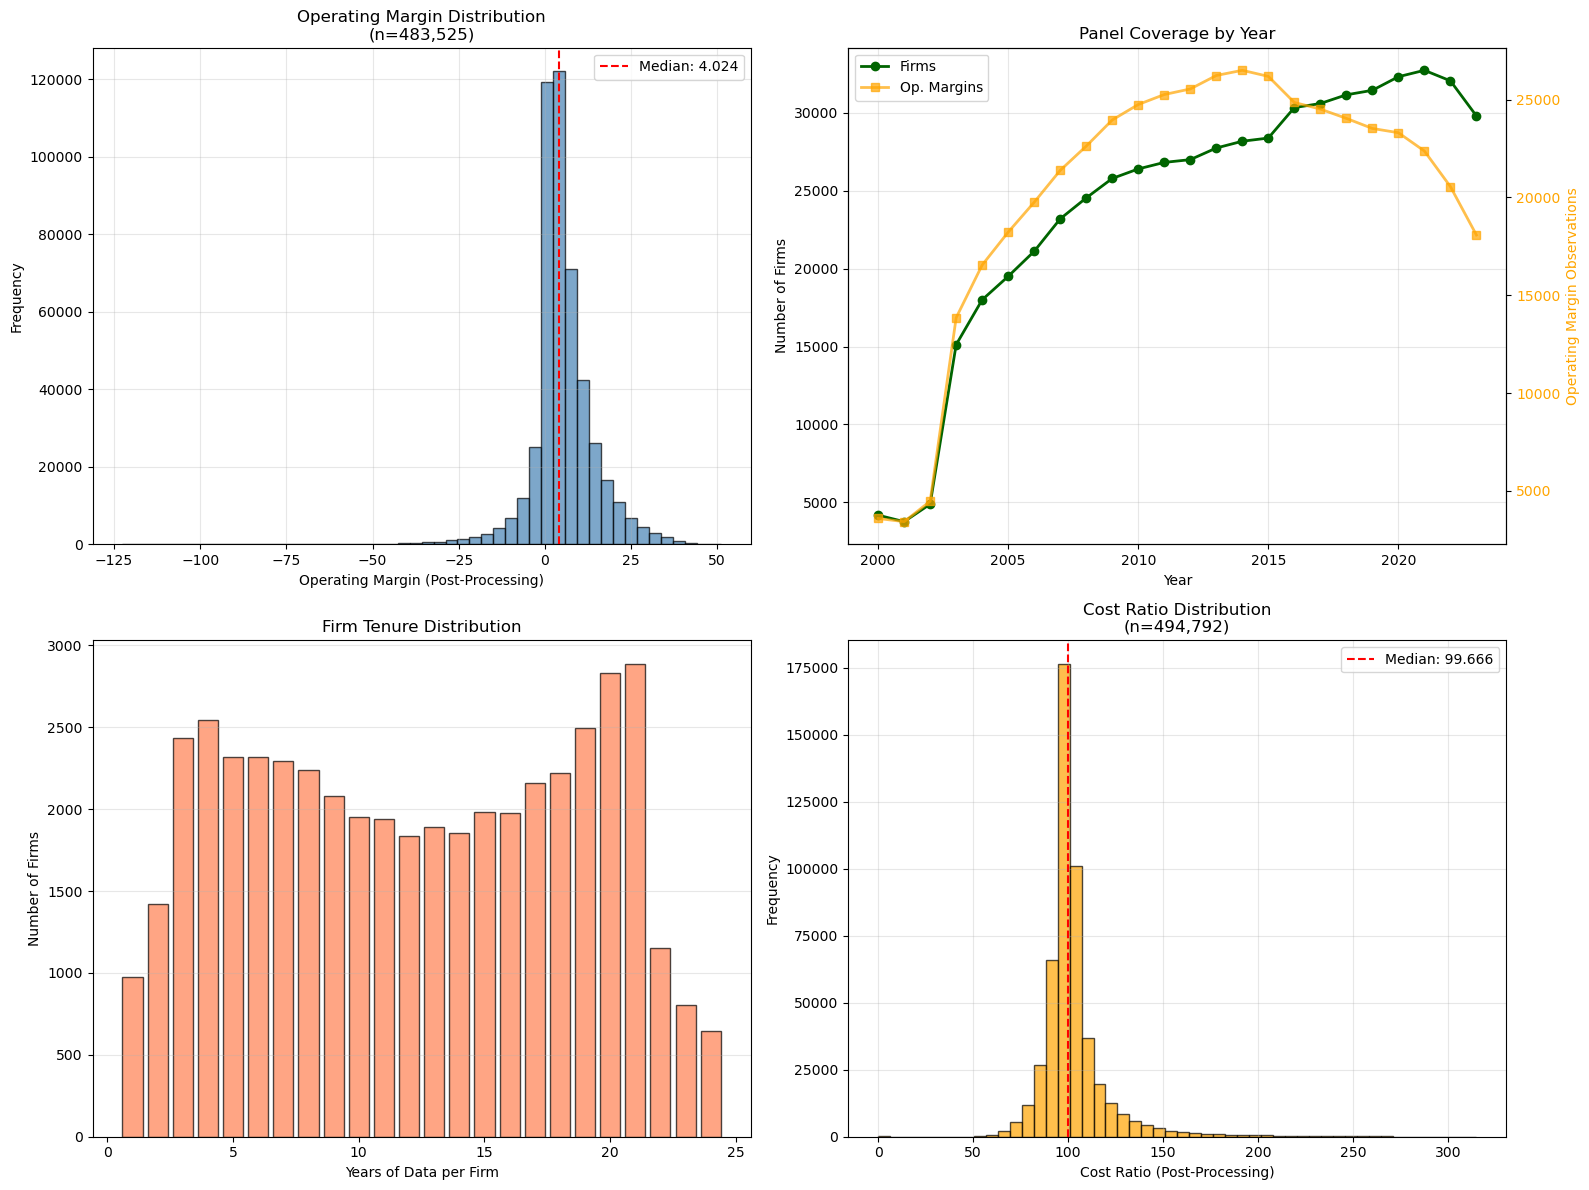

Saving final processed dataset...
Dataset saved to: ../data/source_cleaned/magnusweb_panel_imputed.parquet
   Final shape: (574950, 56)
   File size: 62.5 MB

Step 8 complete: Enrichment, visualization and export finished


In [58]:
print("\n" + "=" * 80)
print("STEP 8: NACE Enrichment, Visualization and Export")
print("=" * 80)

def enrich_with_nace(df: pl.DataFrame) -> pl.DataFrame:
    """Enrich the panel with NACE level 1 and level 2 codes."""
    print("🔧 Enriching panel with NACE level codes...")
    nace_matching_path = os.path.join("..", "data", "source_cleaned", "t_nace_matching.parquet")
    if not os.path.exists(nace_matching_path):
        print(f"   ⚠️ NACE matching file not found at {nace_matching_path}. Skipping.")
        return df

    nace_matching = pl.read_parquet(nace_matching_path)
    nace_for_join = nace_matching.select([
        "magnus_nace", "level1_code", "level2_code", "name_czso_en", "industry_flag"
    ]).unique(subset=["magnus_nace"])

    df_enriched = df.join(
        nace_for_join,
        left_on="main_nace_code",
        right_on="magnus_nace",
        how="left"
    )
    
    matched_count = df_enriched.filter(pl.col("level1_code").is_not_null()).shape[0]
    print(f"   ✅ Successfully matched {matched_count:,} rows ({matched_count/df.shape[0]*100:.1f}%)")
    return df_enriched

def create_data_quality_visualizations(df: pl.DataFrame, validation_results: Dict):
    """
    Create visualizations to document data quality and processing results.
    """
    print("Creating data quality visualizations...")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Operating margin distribution
    if "operating_margin_cal" in df.columns:
        op_margins = df.filter(pl.col("operating_margin_cal").is_not_null())["operating_margin_cal"].to_numpy()
        
        ax1.hist(op_margins, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
        ax1.set_xlabel('Operating Margin (Post-Processing)')
        ax1.set_ylabel('Frequency')
        ax1.set_title(f'Operating Margin Distribution\n(n={len(op_margins):,})')
        ax1.grid(True, alpha=0.3)
        ax1.axvline(np.median(op_margins), color='red', linestyle='--', 
                   label=f'Median: {np.median(op_margins):.3f}')
        ax1.legend()
    
    # 2. Time series coverage
    coverage_by_year = (
        df.group_by("year")
        .agg([
            pl.col("ico").n_unique().alias("firms"),
            pl.col("operating_margin_cal").count().alias("op_margins"),
            pl.col("sales_revenue").count().alias("sales")
        ])
        .sort("year")
    )
    
    years = coverage_by_year["year"].to_numpy()
    firms = coverage_by_year["firms"].to_numpy()
    op_margins = coverage_by_year["op_margins"].to_numpy()
    
    ax2.plot(years, firms, marker='o', linewidth=2, label='Firms', color='darkgreen')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of Firms')
    ax2.set_title('Panel Coverage by Year')
    ax2.grid(True, alpha=0.3)
    
    # Secondary axis for ratio coverage
    ax2_twin = ax2.twinx()
    ax2_twin.plot(years, op_margins, marker='s', linewidth=2, label='Op. Margins', color='orange', alpha=0.7)
    ax2_twin.set_ylabel('Operating Margin Observations', color='orange')
    ax2_twin.tick_params(axis='y', labelcolor='orange')
    
    # Combined legend
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 3. Firm tenure distribution - fixed syntax
    tenure_data = (
        df.group_by("ico")
        .agg(pl.col("year").count().alias("years"))
    )
    
    # Manual value counts
    tenure_dist = (
        tenure_data
        .group_by("years")
        .agg(pl.len().alias("count"))
        .sort("years")
    )
    
    if tenure_dist.shape[0] > 0:
        years_vals = tenure_dist["years"].to_numpy()
        counts = tenure_dist["count"].to_numpy()
        
        ax3.bar(years_vals, counts, alpha=0.7, color='coral', edgecolor='black')
        ax3.set_xlabel('Years of Data per Firm')
        ax3.set_ylabel('Number of Firms')
        ax3.set_title('Firm Tenure Distribution')
        ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Cost ratio distribution
    if "cost_ratio_cal" in df.columns:
        cost_ratios = df.filter(pl.col("cost_ratio_cal").is_not_null())["cost_ratio_cal"].to_numpy()
        
        ax4.hist(cost_ratios, bins=50, alpha=0.7, edgecolor='black', color='orange')
        ax4.set_xlabel('Cost Ratio (Post-Processing)')
        ax4.set_ylabel('Frequency')
        ax4.set_title(f'Cost Ratio Distribution\n(n={len(cost_ratios):,})')
        ax4.grid(True, alpha=0.3)
        ax4.axvline(np.median(cost_ratios), color='red', linestyle='--', 
                   label=f'Median: {np.median(cost_ratios):.3f}')
        ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

def save_final_dataset(df: pl.DataFrame, path: str, validation_results: Dict):
    """
    Save the final processed dataset with metadata.
    """
    print(f"Saving final processed dataset...")
    
    # Save the main dataset
    df.write_parquet(path, compression="snappy")
    
    print(f"Dataset saved to: {path}")
    print(f"   Final shape: {df.shape}")
    print(f"   File size: {os.path.getsize(path) / (1024**2):.1f} MB")
    
    # Create processing summary
    summary = {
        "processing_date": "2025-01-16",
        "input_file": input_path,
        "output_file": path,
        "processing_steps": [
            "Temporal filtering and firm viability checks",
            "Outlier detection using robust z-scores and YoY jumps",
            "Missing data analysis and selective imputation",
            "Economic logic filters and balance sheet consistency",
            "Ratio recalculation and per-year winsorisation",
            "Final validation and quality assessment"
        ],
        "final_statistics": validation_results["structure"],
        "data_quality": validation_results["quality_flags"],
        "winsorisation_bounds": "Per-year bounds applied, see config for quantiles"
    }
    
    return summary

# Enrich with NACE codes
panel = enrich_with_nace(panel)

# Create visualizations
fig = create_data_quality_visualizations(panel, validation_results)

# Save final dataset
processing_summary = save_final_dataset(panel, output_path, validation_results)

print(f"\nStep 8 complete: Enrichment, visualization and export finished")

In [59]:
print("\n" + "=" * 80)
print("DATA PROCESSING SUMMARY")
print("=" * 80)

# Print comprehensive processing summary
print(f"\nProcessing completed successfully!")
print(f"\nFinal dataset statistics:")
print(f"   Input observations: {initial_shape[0]:,}")
print(f"   Final observations: {panel.shape[0]:,}")
print(f"   Retention rate: {panel.shape[0]/initial_shape[0]*100:.1f}%")
print(f"   Final firms: {panel['ico'].n_unique():,}")
print(f"   Average years per firm: {panel.shape[0]/panel['ico'].n_unique():.1f}")

print(f"\nProcessing steps applied:")
print(f"   Temporal filtering (lifecycle-based)")
print(f"   Economic logic filters")
print(f"   Outlier detection and treatment")
print(f"   Missing data analysis and selective imputation")
print(f"   Balance sheet consistency checks")
print(f"   Ratio recalculation and per-year winsorisation")

print(f"\nData quality indicators:")
if 'validation_results' in globals():
    quality_flags = validation_results.get("quality_flags", {})
    print(f"   Low-data firms: {quality_flags.get('low_data_firms', 'N/A'):,}")
    
    # Print ratio statistics
    if "ratios" in validation_results:
        for ratio_name, stats in validation_results["ratios"].items():
            if stats:
                print(f"   {ratio_name}: {stats['count']:,} obs, median = {stats['median']:.4f}")

print(f"\nOutput file: {output_path}")
print(f"\nDataset ready for econometric analysis!")

# Store final metadata for reproducibility
final_metadata = {
    "processing_timestamp": "2025-01-16",
    "initial_observations": initial_shape[0],
    "final_observations": panel.shape[0],
    "retention_rate": panel.shape[0]/initial_shape[0],
    "unique_firms": panel['ico'].n_unique(),
    "time_span": f"{panel['year'].min()}-{panel['year'].max()}",
    "key_ratios_available": [col for col in RATIO_COLS if col in panel.columns],
    "processing_parameters": {
        "outlier_rz_threshold": OUTLIER_RZ_THRESHOLD,
        "yoy_jump_threshold": YOY_JUMP_THRESHOLD,
        "min_reporting_years": MIN_REPORTING_YEARS,
        "winsor_quantiles": (WINSOR_LOWER_Q, WINSOR_UPPER_Q),
        "winsor_growth_quantiles": (WINSOR_GROWTH_LOWER_Q, WINSOR_GROWTH_UPPER_Q),
        "max_balance_sheet_gap": MAX_BALANCE_SHEET_GAP
    }
}

print(f"\nProcessing metadata saved for reproducibility")


DATA PROCESSING SUMMARY

Processing completed successfully!

Final dataset statistics:
   Input observations: 1,754,304
   Final observations: 574,950
   Retention rate: 32.8%
   Final firms: 47,246
   Average years per firm: 12.2

Processing steps applied:
   Temporal filtering (lifecycle-based)
   Economic logic filters
   Outlier detection and treatment
   Missing data analysis and selective imputation
   Balance sheet consistency checks
   Ratio recalculation and per-year winsorisation

Data quality indicators:
   Low-data firms: 7,248
   operating_margin_cal: 483,525 obs, median = 4.0242
   cost_ratio_cal: 494,792 obs, median = 99.6660
   net_margin_cal: 478,743 obs, median = 2.6348

Output file: ../data/source_cleaned/magnusweb_panel_imputed.parquet

Dataset ready for econometric analysis!

Processing metadata saved for reproducibility


In [60]:
# Final verification of the saved dataset
print("Final Dataset Verification:")
print("=" * 50)

# Load and verify the saved dataset
verification_panel = pl.read_parquet(output_path)
print(f"Saved dataset shape: {verification_panel.shape}")
print(f"File size: {os.path.getsize(output_path) / (1024**2):.1f} MB")

# Quick data quality check
print(f"\nQuick quality checks:")
print(f"   Unique firms: {verification_panel['ico'].n_unique():,}")
print(f"   Year range: {verification_panel['year'].min()}-{verification_panel['year'].max()}")
print(f"   Operating margin obs: {verification_panel['operating_margin_cal'].count():,}")
print(f"   Cost ratio obs: {verification_panel['cost_ratio_cal'].count():,}")

print(f"\nDataset successfully processed and saved!")
print(f"Ready for subsequent econometric analysis.")

Final Dataset Verification:
Saved dataset shape: (574950, 56)
File size: 62.5 MB

Quick quality checks:
   Unique firms: 47,246
   Year range: 2000-2023
   Operating margin obs: 483,525
   Cost ratio obs: 494,792

Dataset successfully processed and saved!
Ready for subsequent econometric analysis.
